# Tutorial Session 2
Leader: Oliver Beckstein

Note: This is the **instructor copy**, for the tutorial use the **participant copy** (which is based on this copy with most of the code removed).

## Outline

￼1. trajectory processing (reading)
   - random access
   - dynamically updated trajectory data (AtomGroup.positions)
   - Examples
      - get CV timeseries and plot (AdK angles from DIMS)
      - Ramachandran analysis of trajectory (2D histogram)
      - MAYBE: velocity autocorrelation function of e.g. ions or water with scipy.fft and diffusion coefficient
      - segment trajectory based on order parameter (e.g. detect conformational transition in equilibrium AdK trajectory)
￼   - modifying coordinates
      -translation and rotation
      - RMSD superposition
         - Example: AdK domains

￼2. trajectory processing (writing)
   - writing coordinates (Writer)
   - Example: format changes (Multi PDB/XTC) and concatenation (ChainReader)

3. Bonus: interfacing with other packages
     - Examples:
        - implement LeafletFinder with networkx and analyze bilayer formation in a CGSA-MD simulation (@orbeckst)
        - pandas with MDAnalysis (@dotsdl)

        
       

## Package imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [2]:
import MDAnalysis as mda
print(mda.__version__)

0.12.1


## Data files
Defined `datapath` to point to the directory where you [downloaded the tutorial trajectories](http://becksteinlab.github.io/MDAnalysis-workshop/datadownload.html) to.

In [3]:
import os.path
datapath = os.path.expanduser("~/Workshops/CECAM/tutorial/sandbox")

In [4]:
datapath

'/Users/oliver/Workshops/CECAM/tutorial/sandbox'

## AdK test trajectories
Look again at AdK trajectories...

In [24]:
top = os.path.join(datapath, 'equilibrium', 'adk4AKE.psf')
trj = os.path.join(datapath, 'equilibrium', '1ake_007-nowater-core-dt240ps.dcd')

#psf = os.path.join(datapath, "dims", "adk4ake.psf")
#trj = os.path.join(datapath, "dims", "dims_co_001.dcd")

#coDIMS = [os.path.join(datadir, "dims", "dims_co_{0:03n}.dcd".format(i)) for i in range(1,4)] 
#ocDIMS = [os.path.join(datadir, "dims", "dims_oc_{0:03n}.dcd".format(i)) for i in range(1,4)] 

In [25]:
u = mda.Universe(top, trj)

In [26]:
u

<Universe with 3341 atoms and 3365 bonds>

## Trajectories

The `Universe.trajectory` object is the entry point to all trajectory functionality:

In [27]:
u.trajectory

< DCDReader '/Users/oliver/Workshops/CECAM/tutorial/sandbox/equilibrium/1ake_007-nowater-core-dt240ps.dcd' with 4187 frames of 3341 atoms>

Trajectories have a length in frames and in **ps** (the base MDAnalysis time unit):

In [28]:
u.trajectory.n_frames

4187

In [29]:
len(u.trajectory)

4187

In [30]:
u.trajectory.totaltime

1004880.0205162591

### `Timestep` 

They also contain a `Timestep` object, which holds the **current**
* frame and time
* unitcell dimensions (if available) as `[A, B, C, alpha, beta, gamma]`
* raw positions (and velocities and forces, if available)
* additional data, if defined by the trajectory format

In [74]:
ts = u.trajectory.ts
ts

< Timestep 0 with unit cell dimensions [ 85.53471375  85.53471375  85.53471375  90.          90.          90.        ] >

In [69]:
ts.frame

0

In [70]:
ts.time

0.0

In [71]:
ts.dimensions

array([ 85.53471375,  85.53471375,  85.53471375,  90.        ,
        90.        ,  90.        ], dtype=float32)

In [72]:
ts.positions

array([[  2.87066364,  10.60445595,   9.75028801],
       [  3.10920501,  11.32470894,   9.0389967 ],
       [  3.74609542,  10.24300766,  10.17991066],
       ..., 
       [ -7.49935293,  10.89219856,  12.33476448],
       [ -6.59658432,  10.83427048,  12.92472839],
       [ -8.34826946,  10.59926796,  12.93470669]], dtype=float32)

In [73]:
ts.velocities

NoDataError: This Timestep has no velocities

In [75]:
ts.data

{'dt': 240.00000489999024}

### Moving forward... or anywhere
`Universe.trajectory` behaves a bit like a list of Timesteps:
* index --> `Timestep`: go to frame
* iterate --> `Timestep`: go to each frame in sequence
* slice --> new trajectory iterator

#### Trajectory indexing
Let's move to an arbitrary frame in the trajectory:

In [39]:
u.trajectory[42]

< Timestep 42 with unit cell dimensions [ 85.59259033  85.59259033  85.59259033  90.          90.          90.        ] >

In [41]:
u.trajectory.ts.frame

42

In [42]:
u.trajectory[-23]

< Timestep 4164 with unit cell dimensions [ 85.61685944  85.61685944  85.61685944  90.          90.          90.        ] >

In [44]:
u.trajectory.ts

< Timestep 4164 with unit cell dimensions [ 85.61685944  85.61685944  85.61685944  90.          90.          90.        ] >

Note that you *cannot* "remember" a `Timestep`: The following will *not keep a copy of the timeset at frame 20*:

In [45]:
ts20 = u.trajectory[20]

In [46]:
ts20.frame

20

In [47]:
u.trajectory[42]

< Timestep 42 with unit cell dimensions [ 85.59259033  85.59259033  85.59259033  90.          90.          90.        ] >

In [48]:
ts20

< Timestep 42 with unit cell dimensions [ 85.59259033  85.59259033  85.59259033  90.          90.          90.        ] >

If you *really* want to, you can make a copy (but this is not used very much):

In [49]:
ts42copy = u.trajectory.ts.copy()

In [50]:
ts42copy.frame

42

In [53]:
u.trajectory[2]

< Timestep 2 with unit cell dimensions [ 85.61096191  85.61096191  85.61096191  90.          90.          90.        ] >

In [56]:
ts42copy.frame

42

#### Iteration and Slicing
The **most common usage pattern** in MDAnalysis: Access each frame in a trajectory:

In [65]:
results = []
for ts in u.trajectory:
    results.append(ts.frame)
results = np.array(results)
results

array([   0,    1,    2, ..., 4184, 4185, 4186])

... or arbitrary slices:

In [66]:
results = np.fromiter((ts.frame for ts in u.trajectory[500::1000]), dtype=np.int64)
results

array([ 500, 1500, 2500, 3500])

... and for numpy afficionados, "fancy indexing" also works:

In [67]:
results = np.fromiter((ts.frame for ts in u.trajectory[[10, 20, 10, 0]]), dtype=np.int64)
results

array([10, 20, 10,  0])

*Note*: It does not make sense to create a list of timesteps like
```python
timesteps = [ts for ts in u.trajectory]
```
or
```python
timesteps = list(u.trajectory)
```
because each list item will refer to the same currently active timestep (the first one because at the end of iteration the trajectory rewinds).

## Analyzing trajectories with `Atomgroup`s
Using the raw `Timestep` positions is cumbersome. Moving the time step automatically updates all positions that `Atomgroup.positions` sees at this instance:

In [87]:
u.trajectory[0]
protein = u.select_atoms("protein")

In [88]:
protein

<AtomGroup with 3341 atoms>

In [89]:
protein.center_of_mass()

array([ 0.88438491,  2.20197295, -5.15443377])

What's the current frame?

In [90]:
u.trajectory.ts.frame

0

Move to the last one:

In [91]:
u.trajectory[-1]

< Timestep 4186 with unit cell dimensions [ 85.53918457  85.53918457  85.53918457  90.          90.          90.        ] >

In [92]:
protein.center_of_mass()

array([ 0.5024933 ,  2.12670795, -5.94951837])

#### Example: radius of gyration time series
Collect `(time, radius_of_gyration)` for the protein for frames 0 - 500 and plot $R_{\mathrm{gyr}}(t)$, with time in ns.

In [94]:
protein = u.select_atoms("protein")
results = []
for ts in u.trajectory[:500]:
    results.append((ts.time, protein.radius_of_gyration()))
time, rgyr = np.transpose(results)

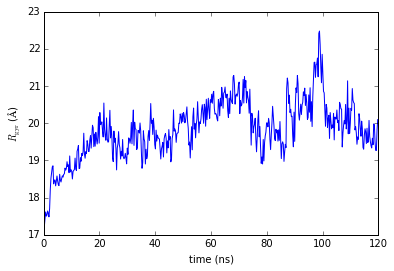

In [105]:
ax = plt.subplot(111)
ax.plot(time/1000, rgyr)
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"$R_{\mathrm{gyr}}$ ($\AA$)")

#### Exercise: Collective variable analysis of AdK

1. Generate timeseries for domain angles, i.e. $t$, $\theta_\mathrm{NMP}$, $\theta_\mathrm{LID}$ (for the first 100 frames)
2. Plot (a) the time series, (b) the angles against each other.
3. Bonus: 
   - analyze some of the other trajectories (e.g. from the "dims" directory)
   - is the radius of gyration correlated with the angles?

In [109]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(ag):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 90:100 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 35:55 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(ag):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = ag.select_atoms("resid 179:185 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 125:153 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

In [117]:
data = np.array([[ts.time, theta_NMP(u), theta_LID(u)] for ts in u.trajectory[:500]])

In [118]:
data[:3]

array([[   0.        ,   51.06463242,  113.44179535],
       [ 240.0000049 ,   51.18372726,  111.32324219],
       [ 480.0000098 ,   48.63728333,  114.36273193]])

In [119]:
time, aNMP, aLID = data.transpose()

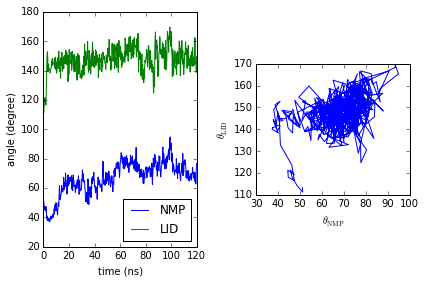

In [126]:
ax1 = plt.subplot(121)
ax1.plot(time/1000, aNMP, label="NMP")
ax1.plot(time/1000, aLID, label="LID")
ax1.set_xlabel("time (ns)")
ax1.set_ylabel("angle (degree)")
ax1.legend(loc="best")
ax2 = plt.subplot(122)
ax2.plot(aNMP, aLID)
ax2.set_xlabel(r"$\theta_\mathrm{NMP}$")
ax2.set_ylabel(r"$\theta_\mathrm{LID}$")
ax2.set_aspect(1)
plt.tight_layout()

## Trajectory manipulation

One can easily modify the coordinates of the current timestep: Either directly in `Timestep.positions` or via `AtomGroup` methods such as `translate` or `rotate`.

In particular, we can do RMSD fitting.


## Writing trajectories and selections
Writing out coordinates; introduce the selection writer (cross package).

## Extra 